In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/faster_rcnn

/content/drive/MyDrive/faster_rcnn


In [ ]:
cd vision

/content/drive/MyDrive/faster_rcnn/vision


In [ ]:
!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
from vision.references.detection.engine import train_one_epoch, evaluate
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import utils



In [ ]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            if xmin == xmax or ymin == ymax:
              continue
            else:
              boxes.append([xmin, ymin, xmax, ymax])
              labels.append(coco_annotation[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if boxes.ndim == 1:
            boxes = torch.zeros(0, 4)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Tensorise img_id
        img_id = img_id

        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())

    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
train_data_dir = './coco/train'
train_coco = './coco/train/_annotations.coco.json'
valid_data_dir = './coco/valid'
valid_coco = './coco/valid/_annotations.coco.json'
test_data_dir = './coco/test'
test_coco = './coco/test/_annotations.coco.json'

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

val_dataset = myOwnDataset(root=valid_data_dir,
                          annotation=valid_coco,
                          transforms=get_transform()
                          )

test_dataset = myOwnDataset(root=test_data_dir,
                          annotation=test_coco,
                          transforms=get_transform()
                          )

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=10,
                                          shuffle=True,
                                          collate_fn=collate_fn)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=10,
                                         shuffle=False,
                                         collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=10,
                                          shuffle=False,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=11.69s)
creating index...
index created!
loading annotations into memory...
Done (t=1.64s)
creating index...
index created!
loading annotations into memory...
Done (t=0.88s)
creating index...
index created!


In [ ]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


In [ ]:
model = get_model_instance_segmentation(4)

device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 84.4MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()


True

In [ ]:
num_epochs = 20

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)


In [ ]:
for epoch in range(num_epochs):
    # 1 에포크동안 학습하고, 10회 마다 출력합니다
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # # 학습률을 업데이트 합니다
    lr_scheduler.step()
    # # vaild 데이터셋에서 평가를 합니다
    with torch.no_grad():
       evaluate(model, val_loader, device=device)

print("That's it!")

Epoch: [0]  [  0/201]  eta: 0:06:02  lr: 0.000030  loss: 3.0440 (3.0440)  loss_classifier: 1.7641 (1.7641)  loss_box_reg: 0.1166 (0.1166)  loss_objectness: 1.0835 (1.0835)  loss_rpn_box_reg: 0.0798 (0.0798)  time: 1.8053  data: 0.0442  max mem: 9210
Epoch: [0]  [ 10/201]  eta: 0:05:36  lr: 0.000280  loss: 1.9513 (1.8631)  loss_classifier: 1.3552 (1.2218)  loss_box_reg: 0.1184 (0.1205)  loss_objectness: 0.4361 (0.4663)  loss_rpn_box_reg: 0.0479 (0.0545)  time: 1.7619  data: 0.0368  max mem: 9368
Epoch: [0]  [ 20/201]  eta: 0:05:20  lr: 0.000529  loss: 1.0146 (1.3454)  loss_classifier: 0.3596 (0.7494)  loss_box_reg: 0.1231 (0.1320)  loss_objectness: 0.3285 (0.4082)  loss_rpn_box_reg: 0.0479 (0.0559)  time: 1.7683  data: 0.0350  max mem: 9368
Epoch: [0]  [ 30/201]  eta: 0:05:03  lr: 0.000779  loss: 0.7923 (1.1636)  loss_classifier: 0.2517 (0.6034)  loss_box_reg: 0.1495 (0.1520)  loss_objectness: 0.2600 (0.3527)  loss_rpn_box_reg: 0.0631 (0.0554)  time: 1.7825  data: 0.0331  max mem: 9368


In [ ]:
torch.save(model.state_dict(),f'model_resnet50_pre=True_{num_epochs}.pt')

In [ ]:
model.load_state_dict(torch.load(f'model_resnet50_pre=True_{num_epochs}.pt'))

<All keys matched successfully>

In [ ]:
def plot_image_from_output(img, annotation):

    img = img.cpu().permute(1, 2, 0)

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1:
            rect = patches.Rectangle(
                (xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='r', facecolor='none')

        elif annotation['labels'][idx] == 2:

            rect = patches.Rectangle(
                (xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='g', facecolor='none')

        else:

            rect = patches.Rectangle(
                (xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='orange', facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)):
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']):
            if score > threshold:
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list].cpu()
        preds[id]['labels'] = preds[id]['labels'][idx_list].cpu()
        preds[id]['scores'] = preds[id]['scores'][idx_list].cpu()

    return preds


In [ ]:
with torch.no_grad():
    # batch size of the test set = 2
    for imgs, annotations in test_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[214.3205,  25.6314, 392.4644, 413.1201],
        [355.4546, 210.6180, 383.0287, 261.6206]]), 'labels': tensor([1, 1]), 'scores': tensor([0.9564, 0.9044])}, {'boxes': tensor([[121.9516, 108.0429, 203.4571, 408.3040],
        [ 62.8635, 111.0979, 119.0484, 201.3691],
        [145.0212,   0.0000, 218.8168, 125.8210]]), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.9868, 0.9815, 0.9803])}, {'boxes': tensor([[119.3464, 211.7450, 204.8046, 303.4875],
        [193.4707, 106.2563, 253.6742, 139.8566]]), 'labels': tensor([2, 2]), 'scores': tensor([0.9874, 0.9675])}, {'boxes': tensor([[170.1023, 149.9793, 220.7505, 230.4861],
        [141.8005, 174.3127, 164.9647, 198.6500],
        [140.2325, 174.2141, 152.1723, 200.1138],
        [219.0393, 129.0128, 256.2684, 152.2867]]), 'labels': tensor([3, 3, 3, 3]), 'scores': tensor([0.9646, 0.8027, 0.7133, 0.6827])}, {'boxes': tensor([[ 39.0633, 284.1160, 179.3206, 318.6691]]), 'labels': tensor([1]), 'scores': tensor([0.6624])}, {'

Target :  tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


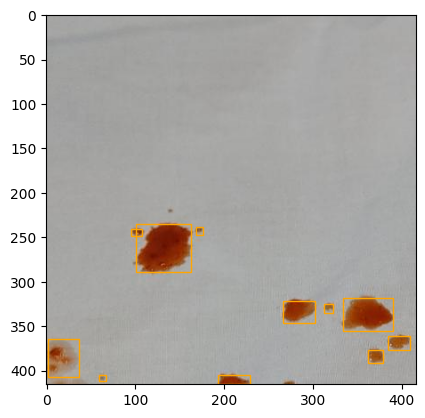

Prediction :  tensor([3, 3, 3, 3, 3, 3, 3, 3])


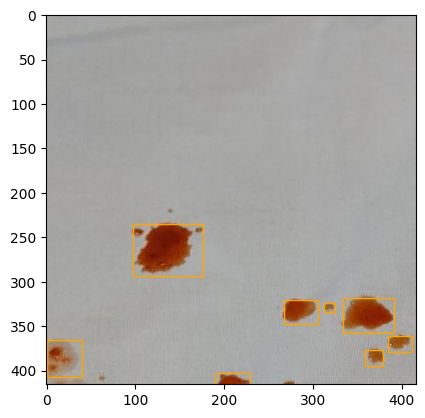

In [ ]:
_idx = 8
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

In [ ]:
with torch.no_grad():
       evaluate(model, test_loader, device=device)

creating index...
index created!
Test:  [ 0/10]  eta: 0:00:09  model_time: 0.8091 (0.8091)  evaluator_time: 0.0767 (0.0767)  time: 0.9266  data: 0.0349  max mem: 5530
Test:  [ 9/10]  eta: 0:00:00  model_time: 0.7669 (0.7338)  evaluator_time: 0.0394 (0.0389)  time: 0.8098  data: 0.0316  max mem: 5530
Test: Total time: 0:00:08 (0.8100 s / it)
Averaged stats: model_time: 0.7669 (0.7338)  evaluator_time: 0.0394 (0.0389)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.535
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.288
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.151
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.443
 Average Recall     (AR) @[ IoU=